<a href="https://colab.research.google.com/github/CalderonJh/hate-speech-detector/blob/main/hate-speech-detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Dependencias
#@markdown Instalar si no han sido instaladas anteriormente
# !pip install swifter
# !pip install tensorflow

# Librerias necesarias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import *
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
pd.__version__

2.18.0


'2.2.2'

# Dataset
A continuación, se referencian los datasets usados para la realización del trabajo

In [ ]:
# Hate Speech Detection curated Dataset🤬
df1 = pd.read_csv('https://www.dropbox.com/scl/fi/jfgpwaw4nd7jdvt9g3y2r/HateSpeechDatasetBalanced.csv?rlkey=mo4h2qi7c5olatmwpoeufwrbk&e=1&st=y0ps81o9&dl=1')

In [ ]:
# Hate Speech and Offensive Language Dataset
df2 = pd.read_csv('https://drive.google.com/uc?export=download&id=1pVBJ_pa7M7in88lVvNTSaLrbr8M9EKNN')

In [ ]:
# Dynamically Generated Hate Speech Dataset - entries
df3 = pd.read_csv('https://drive.google.com/uc?export=download&id=11JmTdBaOKsp--OtsER_KJrL0hAnIv74f')

# Tratamiento y exploracion de datos




## Dataframe 1

In [ ]:
print("Las dimensiones son: ", df1.shape)
print(df1.info())
print("\nDuplicados: ", df1.duplicated().sum())
df1

Las dimensiones son:  (726119, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726119 entries, 0 to 726118
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  726119 non-null  object
 1   Label    726119 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 11.1+ MB
None

Duplicados:  25046


,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1
...,...,...
726114,i mute this telecasting and played kanye west ...,1
726115,but hell yeah he s not a bachelor but looooooo...,1
726116,great video musician but s not my musician lol...,1
726117,not great pop video yeah he s not a pedophile ...,1


In [ ]:
df1.rename(columns={'Label': 'etiqueta', 'Content': 'mensaje'}, inplace=True)
df1.head()

,mensaje,etiqueta
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


## Dataframe 2

In [ ]:
print("Las dimensiones son: ", df2.shape)
print(df2.info())
print("Duplicados: ", df2.duplicated().sum())
print("Porcentaje de etiqueta (0: Hate, 1: Offensive, 2: Neither):", df2['class'].value_counts(normalize=True))
df2

Las dimensiones son:  (24783, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB
None
Duplicados:  0
Porcentaje de etiqueta (0: Hate, 1: Offensive, 2: Neither): class
1    0.774321
2    0.167978
0    0.057701
Name: proportion, dtype: float64


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [ ]:
df2.rename(columns={df2.columns[0]: 'id', 'class': 'etiqueta', 'tweet': 'mensaje'}, inplace=True)
df2.drop(columns=['count', 'hate_speech', 'offensive_language', 'neither', 'id'], inplace=True) # Se eliminan las columnas que no van a ser necesarias, para igualar con los demas datasets
df2['etiqueta'] = df2['etiqueta'].replace({0: 1, 1: 1, 2: 0}) # 0 indica que no hay discurso de odio, 1 indica que en el mensaje si hay discurso de odio
df2.head()

,etiqueta,mensaje
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## Dataframe 3

In [ ]:
print("Las dimensiones son: ", df3.shape)
print(df3.info())
print("Duplicados: ", df3.duplicated().sum())
print("Porcentaje de etiqueta:", df3['label'].value_counts(normalize=True))
df3.head()

Las dimensiones son:  (40623, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40623 entries, 0 to 40622
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      40623 non-null  int64  
 1   id              40623 non-null  object 
 2   text            40623 non-null  object 
 3   label           40623 non-null  object 
 4   type            40623 non-null  object 
 5   model_wrong     26097 non-null  object 
 6   db.model_preds  26097 non-null  float64
 7   status          40623 non-null  object 
 8   round           40623 non-null  object 
 9   split           40623 non-null  object 
 10  annotator       40623 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 3.4+ MB
None
Duplicados:  0
Porcentaje de etiqueta: label
hate       0.544618
nothate    0.455382
Name: proportion, dtype: float64


,Unnamed: 0,id,text,label,type,model_wrong,db.model_preds,status,round,split,annotator
0,1,10000,It should be legal for a husband to rape his wife,hate,notgiven,True,0.97457,dynabench entry,1,train,gnzuctwed3
1,2,10001,dalits are lowlife scum,hate,notgiven,False,0.08233,dynabench entry,1,test,cagnluiznm
2,3,10002,dalits are lowlives,hate,notgiven,True,0.92319,dynabench entry,1,train,cagnluiznm
3,4,10003,It was a better world when women dare not ques...,hate,notgiven,True,0.99006,dynabench entry,1,test,gnzuctwed3
4,5,10004,I don't work this hard so that those immigrant...,hate,notgiven,True,0.98836,dynabench entry,1,train,cagnluiznm


In [ ]:
df3.drop(columns=[df3.columns[0], 'id', 'type', 'model_wrong', 'db.model_preds', 'status', 'round', 'split', 'annotator'], inplace=True) # Se eliminan las columnas que no van a ser necesarias, para igualar con los demas datasets
df3.rename(columns={'label': 'etiqueta', 'text': 'mensaje'}, inplace=True)
df3['etiqueta'] = df3['etiqueta'].replace({'hate': 1, 'nothate': 0}) # 0 indica que no hay discurso de odio, 1 indica que en el mensaje si hay discurso de odio
df3.head()

<ipython-input-14-33667d843c69>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df3['etiqueta'] = df3['etiqueta'].replace({'hate': 1, 'nothate': 0}) # 0 indica que no hay discurso de odio, 1 indica que en el mensaje si hay discurso de odio


,mensaje,etiqueta
0,It should be legal for a husband to rape his wife,1
1,dalits are lowlife scum,1
2,dalits are lowlives,1
3,It was a better world when women dare not ques...,1
4,I don't work this hard so that those immigrant...,1


## Union de todos los dataframes en uno

In [ ]:
df = pd.concat([df1, df2, df3], axis=0).reset_index(drop=True) # se va a trabajar sobre este nuevo dataframe
df.head()

,mensaje,etiqueta
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791525 entries, 0 to 791524
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   mensaje   791525 non-null  object
 1   etiqueta  791525 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.1+ MB


In [ ]:
#@title Duplicados
# Agrupar los mensajes duplicados y listar sus índices
duplicados = df[df['mensaje'].duplicated(keep=False)]  # todas las ocurrencias duplicadas
grupo_indices = duplicados.groupby('mensaje').apply(lambda x: x.index.tolist())

# Mostrar los mensajes con sus índices duplicados
for i, (mensaje, indices) in enumerate(grupo_indices.items()):
    if i >= 100:
      break
    print(f"Mensaje: {mensaje}")
    print(f"Índices: {indices}")
    print("-" * 40)

Mensaje: ...
Índices: [449164, 449983, 464572, 469775, 478672, 479571, 484484, 489444, 489575, 491207, 491580, 499612, 505735, 505736, 506675, 506676, 515680, 535416, 536800, 541851, 558895, 558896, 564984, 570932, 582312, 611216, 613700, 683659, 685684, 686408, 686799, 687424, 688436, 688875, 692056, 692999, 693595, 696400, 699039, 701516, 715563]
----------------------------------------
Mensaje: ... 。
Índices: [488236, 488359]
----------------------------------------
Mensaje: ......
Índices: [469576, 488163, 612424, 686467, 699375]
----------------------------------------
Mensaje: 1 ।
Índices: [463236, 561807, 578351, 684151, 695860, 696464, 699663]
----------------------------------------
Mensaje: 1 ॥
Índices: [476599, 686144, 687135]
----------------------------------------
Mensaje: 10 ।
Índices: [475327, 725460]
----------------------------------------
Mensaje: 11 ॥
Índices: [488072, 690160, 701300]
----------------------------------------
Mensaje: 12 ।
Índices: [496096, 686064, 6

<ipython-input-17-98f91d9c9c4d>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grupo_indices = duplicados.groupby('mensaje').apply(lambda x: x.index.tolist())


In [ ]:
#@title Eliminar duplicados
df = df.drop_duplicates(subset='mensaje')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 760762 entries, 0 to 791522
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   mensaje   760762 non-null  object
 1   etiqueta  760762 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 17.4+ MB


In [ ]:
df.describe()

,etiqueta
count,760762.000000
mean,0.524523
std,0.499399
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
print("Porcentaje de etiqueta:", df['etiqueta'].value_counts(normalize=True))

Porcentaje de etiqueta: etiqueta
1    0.524523
0    0.475477
Name: proportion, dtype: float64


In [ ]:
noHate_msg = df[df['etiqueta'] == 0][100:110]
Hate_msg = df[df['etiqueta'] == 1][100:110]

print('**Ejemplos de mensajes sin hate**')
for i in noHate_msg['mensaje']:
  print('.', i)

print('**Ejemplos de mensajes con hate**')
for i in Hate_msg['mensaje']:
  print('.', i)

**Ejemplos de mensajes sin hate**
. i apologize for my ignorance
. i do and t think anyone is insinuating that whatever are equal to non whites or that whatever would ignore white nations
. these people have no idea about who they are or where they came from and any knowledge that they do have has guilt attached to it
. if whites did have some knowledge and a little more recognition what a slut put out there i think most of them would feel a little more pride of who they are and stick to the white race
. if a person is white and he is a christian or a pagan then i consider him as my brother or sister no matter whatever profession he is into
. can you give any examples of progress made by skinheads or the klein
. seems to me they are in precipitous decline
. i have been around here for four years and seen almost no class divide
. i do not really like even talking about it because i fear whatever will create a division where there is none
. racist woman rant in london part youtube origin

## Analisis del texto

Mensaje mas corto:  1 caracteres
Mensaje mas largo:  9998 caracteres
Mensaje con menos palabras:  1 palabras
Mensaje con mas palabras:  402 palabras


Text(0, 0.5, 'Frecuencia')

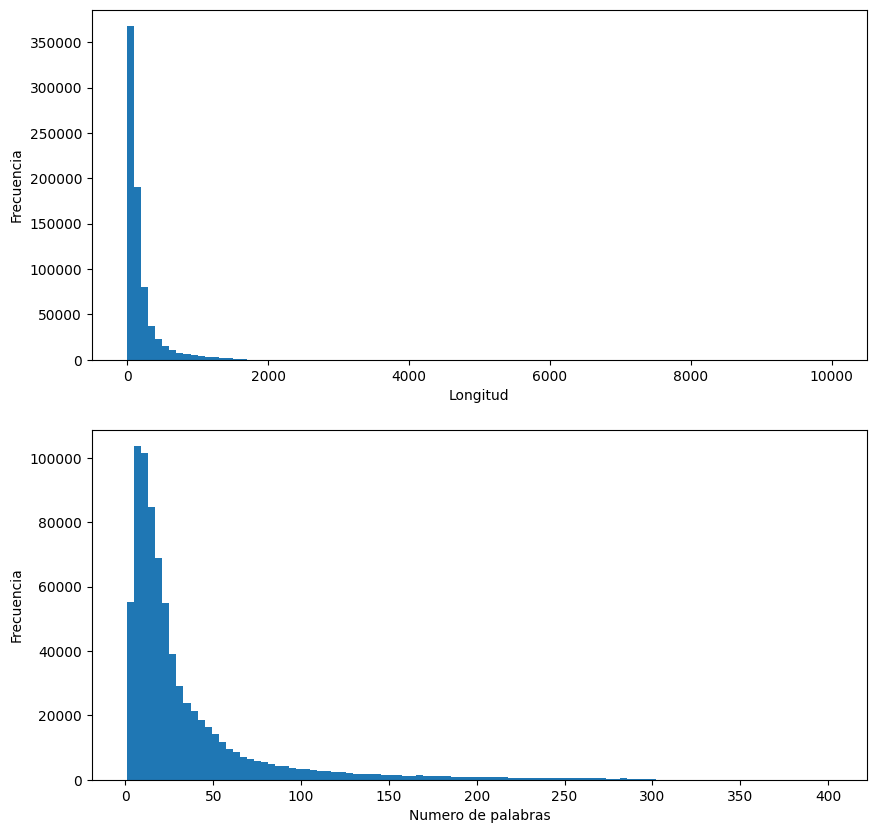

In [ ]:
# @title Longitud de los mensajes
lon_men = df['mensaje'].str.len() # longitud del mensaje
print('Mensaje mas corto: ', min(lon_men), 'caracteres')
print('Mensaje mas largo: ', max(lon_men), 'caracteres')
pal_men = df['mensaje'].str.split().apply(len) # numero de palabras por mensaje
print('Mensaje con menos palabras: ', min(pal_men), 'palabras')
print('Mensaje con mas palabras: ', max(pal_men), 'palabras')



plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.hist(lon_men, bins=100)
plt.xlabel('Longitud')
plt.ylabel('Frecuencia')
plt.subplot(2, 1, 2)
plt.hist(pal_men, bins=100)
plt.xlabel('Numero de palabras')
plt.ylabel('Frecuencia')

In [ ]:
# @title Caracteristicas lexicas
pal_mayus = df['mensaje'].str.isupper().sum() #Mensajes completamente en mayusculas

datos_mayus = pd.DataFrame({'Caracteristica': ['Mayuscula', 'Sin Mayuscula'], 'Cantidad': [pal_mayus, len(df) - pal_mayus]})
print(datos_mayus)

  Caracteristica  Cantidad
0      Mayuscula       160
1  Sin Mayuscula    760602


In [ ]:
# @title Analisis de vocabulario BoW
#@markdown Para poder visualizar los mensajes de mejor manera se utiliza una BoW que representa la frecuencia de palabras en cada mensaje

# Se preprocesa el texto para eliminar signos, tildes, etc.
df['mensaje_pre'] = df['mensaje'].str.lower()\
    .str.replace(r'http\S+|www.\S+', '', regex=True)\
    .str.replace(r'@\w+|#\w+', '', regex=True)\
    .str.replace(r'[^a-záéíóúüñ\s]', '', regex=True)\
    .str.replace(r'\brt\b', '', regex=True)

In [ ]:
#@title BoW
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["mensaje_pre"])

# Convertir a DataFrame de manera eficiente
df_bow = pd.DataFrame.sparse.from_spmatrix(X, columns=vectorizer.get_feature_names_out())

print(df_bow.head())

   aa  aaa  aaaa  aaaaa  aaaaaa  aaaaaaa  aaaaaaaa  aaaaaaaaa  aaaaaaaaaa  \
0   0    0     0      0       0        0         0          0           0   
1   0    0     0      0       0        0         0          0           0   
2   0    0     0      0       0        0         0          0           0   
3   0    0     0      0       0        0         0          0           0   
4   0    0     0      0       0        0         0          0           0   

   aaaaaaaaaaa  ...  zzzzzzus  zzzzzzz  zzzzzzzz  zzzzzzzzzzzzzzz  \
0            0  ...         0        0         0                0   
1            0  ...         0        0         0                0   
2            0  ...         0        0         0                0   
3            0  ...         0        0         0                0   
4            0  ...         0        0         0                0   

   zzzzzzzzzzzzzzzzz  zzzzzzzzzzzzzzzzzzzzz  zzzzzzzzzzzzzzzzzzzzzzzzzzzzzz  \
0                  0                      0

<ipython-input-27-60bfb793e8ee>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mensaje_bow.index, y=mensaje_bow.values, palette="Blues_r", ax=ax)
<ipython-input-27-60bfb793e8ee>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mensaje_bow.index, rotation=45, ha="right")
<ipython-input-27-60bfb793e8ee>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mensaje_bow.index, y=mensaje_bow.values, palette="Blues_r", ax=ax)
<ipython-input-27-60bfb793e8ee>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a

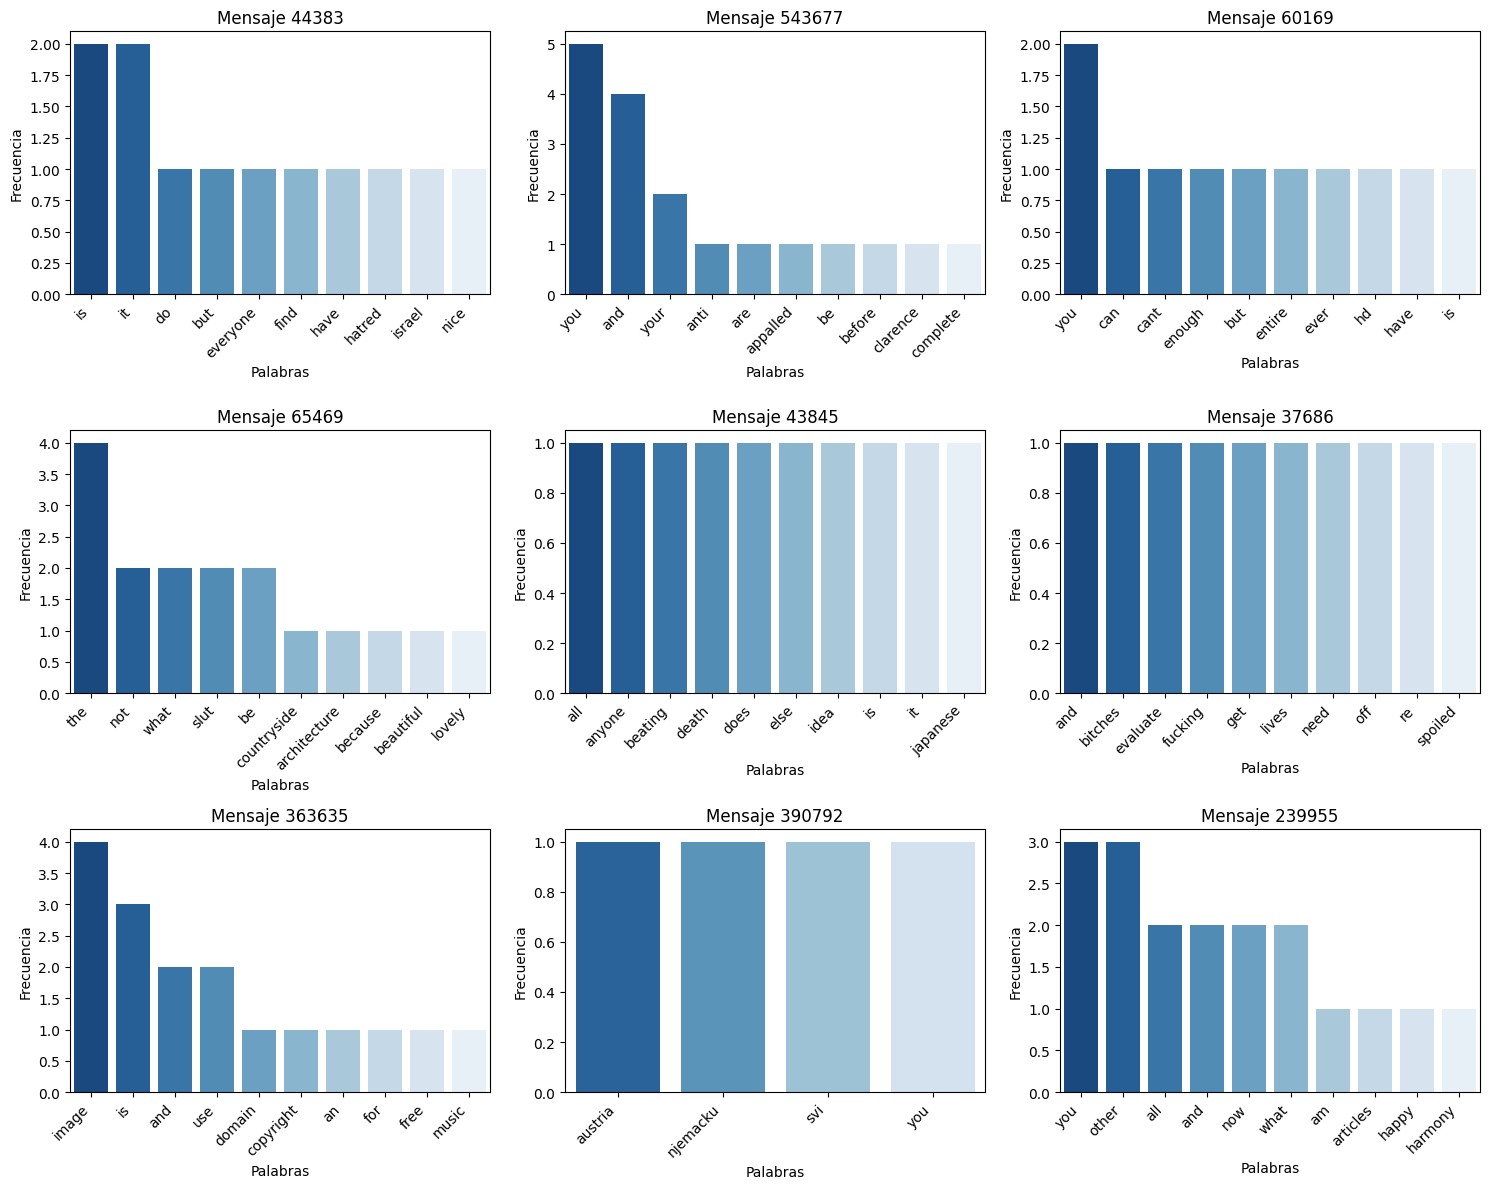

In [ ]:
#@title Grafica de algunos ejemplos de BoW

sample = df_bow.sample(n=9, random_state=42) #Muestra aleatoria

fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Iterar sobre cada mensaje seleccionado
for idx, (i, row) in enumerate(sample.iterrows()):
    # Obtener palabras con frecuencia > 0
    mensaje_bow = row[row > 0].sort_values(ascending=False)

    # Seleccionar las 10 palabras más frecuentes
    mensaje_bow = mensaje_bow[:10]

    # Ubicar en la subgráfica correspondiente
    ax = axes[idx // 3, idx % 3]

    sns.barplot(x=mensaje_bow.index, y=mensaje_bow.values, palette="Blues_r", ax=ax)

    ax.set_title(f"Mensaje {i}")
    ax.set_xlabel("Palabras")
    ax.set_ylabel("Frecuencia")
    ax.set_xticklabels(mensaje_bow.index, rotation=45, ha="right")

# Ajustar layout para evitar solapamientos
plt.tight_layout()
# plt.show()

denial of normal the con be asked to comment on tragedies an emotional retard
just by being able to tweet this insufferable bullshit proves trump a nazi you vagina
that is retarded you too cute to be single that is life
thought of a real badass mongol style declaration of war the attackers capture a citizen of the soon to be


<ipython-input-28-5e558a6794e3>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mensaje_bow.index, y=mensaje_bow.values, palette="Blues_r", ax=ax)
<ipython-input-28-5e558a6794e3>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mensaje_bow.index, rotation=45, ha="right")
<ipython-input-28-5e558a6794e3>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mensaje_bow.index, y=mensaje_bow.values, palette="Blues_r", ax=ax)
<ipython-input-28-5e558a6794e3>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a

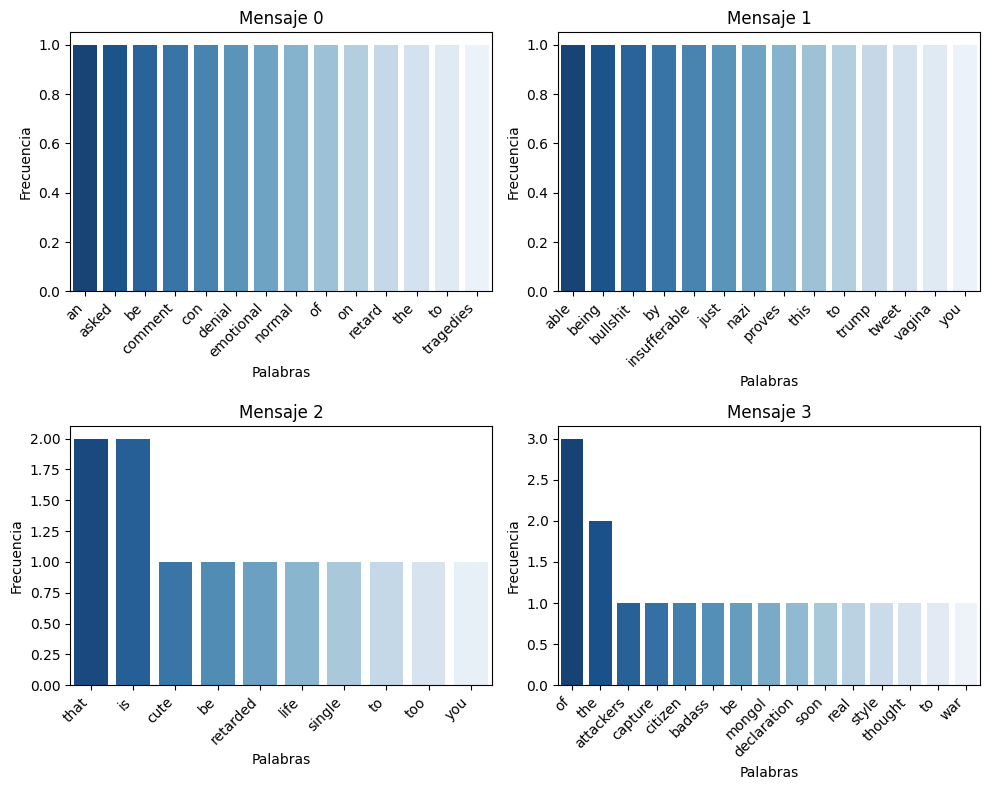

In [ ]:
# @title Ejemplo de BoW con mensajes de odio
hate_sample = df_bow[0:4] #Muestra de mensajes de odio
[print(msg) for msg in df['mensaje_pre'][0:4]]
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Iterar sobre cada mensaje seleccionado
for idx, (i, row) in enumerate(hate_sample.iterrows()):
    # Obtener palabras con frecuencia > 0
    mensaje_bow = row[row > 0].sort_values(ascending=False)

    # Seleccionar las  palabras más frecuentes
    mensaje_bow = mensaje_bow[:50]

    # Ubicar en la subgráfica correspondiente
    ax = axes[idx // 2, idx % 2]

    sns.barplot(x=mensaje_bow.index, y=mensaje_bow.values, palette="Blues_r", ax=ax)

    ax.set_title(f"Mensaje {i}")
    ax.set_xlabel("Palabras")
    ax.set_ylabel("Frecuencia")
    ax.set_xticklabels(mensaje_bow.index, rotation=45, ha="right")

# Ajustar layout para evitar solapamientos
plt.tight_layout()
#plt.show()

# Limpieza del texto
*Nota: No correr, el resultado de la limpieza se guardo en csv que se carga más adelante. Todo ha sido comentado para evitar cualquier problema.*



In [ ]:
# import re           # Para regex
# import nltk         # Librería de NLP básica
# import spacy        # Para lematización

# from nltk.corpus import stopwords

# nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))
# stop_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [ ]:
# nlp = spacy.load("en_core_web_sm")  # Modelo de inglés

In [ ]:
# from tqdm.notebook import tqdm

# def clean_text_pipe(texts):
#     cleaned_texts = []

#     for doc in tqdm(nlp.pipe(texts, batch_size=2000, n_process=-1), total=len(texts)):
#         clean_tokens = [
#             token.lemma_ for token in doc
#             if token.text not in stop_words and not token.is_space
#         ]
#         cleaned_texts.append(" ".join(clean_tokens))

#     return cleaned_texts

# # Aplica el procesamiento con barra de progreso
# df['mensaje_limpio'] = clean_text_pipe(df['mensaje_pre'])

  0%|          | 0/760762 [00:00<?, ?it/s]

In [ ]:
# from collections import Counter

# def count():
#   vocab_counter = Counter()

#   for tokens in tokenized_texts:
#       vocab_counter.update(tokens)

#   # Este diccionario mapea cada palabra a un número único.
#   vocab = {word: idx for idx, (word, _) in enumerate(vocab_counter.items())}

# Tokenizar

In [ ]:
import pandas as pd
# Se carga el csv generado anteriormente en la limpieza de texto
df = pd.read_csv('https://www.dropbox.com/scl/fi/v8q2p4d8u681mxfhgx24b/df_limpio.csv?rlkey=happd5itd9yzpix931x72lr7h&st=rglsjk9x&dl=1')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791525 entries, 0 to 791524
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   mensaje         791525 non-null  object
 1   etiqueta        791525 non-null  int64 
 2   mensaje_pre     791405 non-null  object
 3   mensaje_limpio  790368 non-null  object
dtypes: int64(1), object(3)
memory usage: 24.2+ MB


In [ ]:
df.head()

,mensaje,etiqueta,mensaje_pre,mensaje_limpio
0,denial of normal the con be asked to comment o...,1,denial of normal the con be asked to comment o...,denial normal con ask comment tragedy emotiona...
1,just by being able to tweet this insufferable ...,1,just by being able to tweet this insufferable ...,able tweet insufferable bullshit prove trump n...
2,that is retarded you too cute to be single tha...,1,that is retarded you too cute to be single tha...,retarded cute single life
3,thought of a real badass mongol style declarat...,1,thought of a real badass mongol style declarat...,think real badass mongol style declaration war...
4,afro american basho,1,afro american basho,afro american basho


In [ ]:
import pandas as pd

def reduce_vocab(df, text_column, min_freq=5, max_len=20):
    from collections import Counter
    from tqdm import tqdm

    df[text_column] = df[text_column].fillna('')
    all_words = ' '.join(df[text_column]).split()

    word_counts = Counter(all_words)

    valid_words = {
        word for word, count in word_counts.items()
        if count >= min_freq and len(word) <= max_len
    }

    def reduce(text):
        words = text.split()
        return ' '.join([w for w in words if w in valid_words])

    tqdm.pandas(desc="Progress")
    df['reduced'] = df[text_column].progress_apply(reduce)
    return df

In [ ]:
df = reduce_vocab(df, 'mensaje_limpio')
# tokenized_texts = [text.split() for text in df['cleaned']]

Progress: 100%|██████████| 791525/791525 [00:02<00:00, 272738.65it/s]


# Vectorizar

## TF - IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['reduced'])
y = df['etiqueta'].values

# Machine Learning (ML)

## Multinomial Naive Bayes

Clasificador Naive Bayes que se usa con datos discretos no negativos, usualmente en NLP

In [ ]:
#@title Training

from sklearn.model_selection import *
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [ ]:
#@title Test
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
train_acc = accuracy_score(y_train, model.predict(X_train))
test_acc = accuracy_score(y_test, model.predict(X_test))

print(f"Train: {train_acc:.2f}, Test: {test_acc:.2f}")
s = cross_val_score(model, X, y, cv=KFold(7, shuffle=True), scoring=make_scorer(accuracy_score))
print ("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

              precision    recall  f1-score   support

           0       0.82      0.70      0.75    346019
           1       0.75      0.86      0.80    366354

    accuracy                           0.78    712373
   macro avg       0.79      0.78      0.78    712373
weighted avg       0.78      0.78      0.78    712373

Train: 0.81, Test: 0.78
accuracy 0.792 (+/- 0.00087)


## Decision tree

In [ ]:
#@title Training
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
model = DecisionTreeClassifier(max_depth=15, criterion='entropy')
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=15)

In [ ]:
#@title Test
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
train_acc = accuracy_score(y_train, model.predict(X_train))
test_acc = accuracy_score(y_test, model.predict(X_test))

print(f"Train: {train_acc:.2f}, Test: {test_acc:.2f}")
s = cross_val_score(model, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print ("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

              precision    recall  f1-score   support

           0       0.85      0.41      0.55    153518
           1       0.63      0.93      0.75    163092

    accuracy                           0.68    316610
   macro avg       0.74      0.67      0.65    316610
weighted avg       0.73      0.68      0.65    316610

Train: 0.68, Test: 0.68
accuracy 0.679 (+/- 0.00098)


## Random Forest

In [ ]:
#@title Training
from sklearn.model_selection import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)
model = RandomForestClassifier(n_estimators=150, max_depth=15, criterion='gini', min_samples_split=10, min_samples_leaf=3, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=3, min_samples_split=10,
                       n_estimators=150, n_jobs=-1, random_state=42)

In [ ]:
#@title Test
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
train_acc = accuracy_score(y_train, model.predict(X_train))
test_acc = accuracy_score(y_test, model.predict(X_test))

print(f"Train: {train_acc:.5f}, Test: {test_acc:.5f}")

s = cross_val_score(model, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print ("accuracy %.5f (+/- %.5f)"%(np.mean(s), np.std(s)))

              precision    recall  f1-score   support

           0       0.87      0.44      0.58    230464
           1       0.64      0.94      0.76    244451

    accuracy                           0.70    474915
   macro avg       0.76      0.69      0.67    474915
weighted avg       0.75      0.70      0.67    474915

Train: 0.69703, Test: 0.69600
accuracy 0.69514 (+/- 0.00104)


## Support Vector Machine SVM

In [ ]:
# RAPIDS setup script for Colab (tested)
# Nota: Correr una sola vez
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 592 (delta 125), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (592/592), 194.79 KiB | 1.65 MiB/s, done.
Resolving deltas: 100% (299/299), done.
PLEASE READ FOR 21.06
********************************************************************************************************
Another release, another script change.  We had to revise the script, which now:
1. Does a more comprehensive install
2. Includes BlazingSQL
3. is far easier for everyone to understand and maintain

The script will require you to add these 5 cells to your notebook.  We have also created a new startup template: 
https://colab.research.google.com/drive/1TAAi_szMfWqRfHVfjGSqnGVLr_ztzUM9?usp=sharing

CHANGES T
CELL 1:
    # This get the RAPIDS-Colab install files and test check your GPU.  Run cells 1 and 2 only.
 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
import cupy as cp
import cupyx.scipy.sparse as cpsparse

X_train_gpu = cpsparse.csr_matrix(X_train)
X_test_gpu = cpsparse.csr_matrix(X_test)
y_train_gpu = cp.asarray(y_train)
y_test_gpu = cp.asarray(y_test)

In [ ]:
#@title Training
from cuml.svm import SVC
model = SVC(kernel='rbf', C=0.5)
model.fit(X_train_gpu, y_train_gpu)

SVC()

In [ ]:
#@title Test
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import *

y_pred = cp.asnumpy(model.predict(X_test_gpu))
print(classification_report(cp.asnumpy(y_test_gpu), y_pred))

train_acc = accuracy_score(y_train, cp.asnumpy(model.predict(X_train_gpu)))
test_acc = accuracy_score(y_test, cp.asnumpy(model.predict(X_test_gpu)))

print(f"Train: {train_acc:.5f}, Test: {test_acc:.5f}")

              precision    recall  f1-score   support

           0       0.89      0.82      0.86     38560
           1       0.84      0.91      0.87     40593

    accuracy                           0.86     79153
   macro avg       0.87      0.86      0.86     79153
weighted avg       0.87      0.86      0.86     79153

Train: 0.91312, Test: 0.86455


# Deep Learning (DL) supervisado y no supervisado

## DL Supervisado

In [ ]:
#@title DNN model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= (51326,)),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')     #softmax for multiple classes
])

model.summary()

In [ ]:
#@title Compile and fit the model
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#@title Testing
with tf.device('/device:GPU:0'):
  history = model.fit(X_train,
            y_train,
            epochs=10,
            batch_size=40,
            validation_data=(X_test, y_test))

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## DL No Supervisado

### Gaussian Naive Bayes

In [ ]:
#@title Reduccion de la dimensionalidad
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

## Truncated SVD
svd = TruncatedSVD(n_components=450)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

svd.fit(X_train)

Reduced_X_train = svd.transform(X_train)
Reduced_X_test = svd.transform(X_test)

In [ ]:
#@title Training

from sklearn.model_selection import *
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import *

model = GaussianNB()
model.fit(Reduced_X_train, y_train)

GaussianNB()

In [ ]:
#@title Test
import gc

y_pred = model.predict(Reduced_X_test)
print(classification_report(y_test, y_pred))
train_acc = accuracy_score(y_train, model.predict(Reduced_X_train))
test_acc = accuracy_score(y_test, model.predict(Reduced_X_test))

print(f"Train: {train_acc:.2f}, Test: {test_acc:.2f}")

gc.collect()

              precision    recall  f1-score   support

           0       0.60      0.79      0.68    346019
           1       0.72      0.51      0.60    366354

    accuracy                           0.65    712373
   macro avg       0.66      0.65      0.64    712373
weighted avg       0.66      0.65      0.64    712373

Train: 0.65, Test: 0.65


### Decision tree

In [ ]:
#@title Reduccion de la dimensionalidad
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

## Truncated SVD
svd = TruncatedSVD(n_components=450)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

svd.fit(X_train)

Reduced_X_train = svd.transform(X_train)
Reduced_X_test = svd.transform(X_test)

In [ ]:
#@title Training
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=15, criterion='entropy')
model.fit(Reduced_X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=15)

In [ ]:
#@title Test
import gc

y_pred = model.predict(Reduced_X_test)
print(classification_report(y_test, y_pred))
train_acc = accuracy_score(y_train, model.predict(Reduced_X_train))
test_acc = accuracy_score(y_test, model.predict(Reduced_X_test))

print(f"Train: {train_acc:.2f}, Test: {test_acc:.2f}")

gc.collect()

              precision    recall  f1-score   support

           0       0.76      0.67      0.71    153518
           1       0.72      0.80      0.76    163092

    accuracy                           0.74    316610
   macro avg       0.74      0.73      0.73    316610
weighted avg       0.74      0.74      0.74    316610

Train: 0.80, Test: 0.74


0

### Random Forest

In [ ]:
#@title Reduccion de la dimensionalidad
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

## Truncated SVD
svd = TruncatedSVD(n_components=450)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

svd.fit(X_train)

Reduced_X_train = svd.transform(X_train)
Reduced_X_test = svd.transform(X_test)

In [ ]:
#@title Training
from sklearn.model_selection import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

model = RandomForestClassifier(n_estimators=150, max_depth=15, criterion='gini', min_samples_split=10, min_samples_leaf=3, n_jobs=-1, random_state=42)
model.fit(Reduced_X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=3, min_samples_split=10,
                       n_estimators=150, n_jobs=-1, random_state=42)

In [ ]:
#@title Test
import gc

y_pred = model.predict(Reduced_X_test)
print(classification_report(y_test, y_pred))
train_acc = accuracy_score(y_train, model.predict(Reduced_X_train))
test_acc = accuracy_score(y_test, model.predict(Reduced_X_test))

print(f"Train: {train_acc:.5f}, Test: {test_acc:.5f}")

gc.collect()

              precision    recall  f1-score   support

           0       0.82      0.64      0.72    230464
           1       0.72      0.87      0.79    244451

    accuracy                           0.76    474915
   macro avg       0.77      0.76      0.76    474915
weighted avg       0.77      0.76      0.76    474915

Train: 0.82381, Test: 0.75948


103

## Support Vector Machine SVM

In [ ]:
#@title Reduccion de la dimensionalidad
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

## Truncated SVD
svd = TruncatedSVD(n_components=450)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

svd.fit(X_train)

Reduced_X_train = svd.transform(X_train)
Reduced_X_test = svd.transform(X_test)

In [ ]:
#@title Training
from sklearn.svm import SVC
model = SVC(kernel='rbf', C=0.5)
model.fit(Reduced_X_train, y_train)

In [ ]:
#@title Test
import gc

y_pred = model.predict(Reduced_X_test)
print(classification_report(y_test, y_pred))
train_acc = accuracy_score(y_train, model.predict(Reduced_X_train))
test_acc = accuracy_score(y_test, model.predict(Reduced_X_test))

print(f"Train: {train_acc:.5f}, Test: {test_acc:.5f}")

gc.collect()

### DNN

In [ ]:
#@title Reduccion de la dimensionalidad
import tensorflow as tf
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

## Truncated SVD
svd = TruncatedSVD(n_components=450)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

svd.fit(X_train)

Reduced_X_train = svd.transform(X_train)
Reduced_X_test = svd.transform(X_test)

In [ ]:
#@title DNN model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape= (450,)),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')     #softmax for multiple classes
])

model.summary()

model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#@title Testing
import matplotlib.pyplot as plt

with tf.device('/device:GPU:0'):
  history = model.fit(Reduced_X_train,
            y_train,
            epochs=10,
            batch_size=40,
            validation_data=(Reduced_X_test, y_test))

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
#@title visualizacion de clusters
#@title vectorize

dfs = df.sample(n=5000, random_state=42)
dfs = reduce_vocab(dfs)
dfs['reduced'] = dfs['reduced'].fillna('')

from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorización
vectorizer = TfidfVectorizer(
    max_features=20000,  # limite de features
    min_df=5,
    max_df=0.9           # ignora términos muy comunes
)
X_vect = vectorizer.fit_transform(dfs['reduced'])

In [ ]:
from sklearn.cluster import KMeans
import umap.umap_ as umap
import matplotlib.pyplot as plt

def visualizar_clusters_umap(X_vect, n_clusters=2):
    # reducción de dimensionalidad
    reducer = umap.UMAP(n_components=2, random_state=42)
    X_umap = reducer.fit_transform(X_vect)

    # clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_umap)

    # visualización
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=clusters, cmap='tab10', s=2, alpha=0.6)
    plt.title("UMAP + KMeans")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.grid(True)
    plt.show()

visualizar_clusters_umap(X_vect, n_clusters=2)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# PCA a 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vect.toarray())

# KMeans con 2 clústeres
kmeans_pca = KMeans(n_clusters=2, random_state=42)
clusters_pca = kmeans_pca.fit_predict(X_vect)

# Visualización
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_pca, cmap='coolwarm', s=5, alpha=0.6)
plt.title('PCA + KMeans')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.decomposition import PCA

# reducir con PCA
X_pca_50 = PCA(n_components=50).fit_transform(X_vect.toarray())

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_pca_50)

# clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_vect)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='coolwarm', s=5, alpha=0.6)
plt.title('t-SNE + KMeans')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [ ]:
#@title vectorize

df = df.sample(n=1000, random_state=42)
df = reduce_vocab(df)

# Opcional: limitar vocabulario y preprocesar nulos
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import gc

# Paso 1: Reemplazar nulos
df['reduced'] = df['reduced'].fillna('')

# Vectorización
vectorizer = TfidfVectorizer(
    max_features=20000,  # limite de features
    min_df=5,
    max_df=0.9           # ignora términos muy comunes
)
X_vect = vectorizer.fit_transform(df['reduced'])

In [ ]:
#@title load dataset

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
# se guardó el csv generado
df = pd.read_csv('https://www.dropbox.com/scl/fi/v8q2p4d8u681mxfhgx24b/df_limpio.csv?rlkey=happd5itd9yzpix931x72lr7h&st=rglsjk9x&dl=1')
import pandas as pd

def reduce_vocab(df, text_column='mensaje_limpio', min_freq=5, max_len=20):
    from collections import Counter
    from tqdm import tqdm

    df[text_column] = df[text_column].fillna('')
    all_words = ' '.join(df[text_column]).split()

    word_counts = Counter(all_words)

    valid_words = {
        word for word, count in word_counts.items()
        if count >= min_freq and len(word) <= max_len
    }

    def reduce(text):
        words = text.split()
        return ' '.join([w for w in words if w in valid_words])

    tqdm.pandas(desc="Progress")
    df['reduced'] = df[text_column].progress_apply(reduce)
    return df